In [45]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
import matplotlib.ticker as mticker

In [46]:
# Constants

D = 100
z_H = 100
C_star = 4.5
f = 1e-4
kappa = 0.4
z_0 = 0.0001
s_x = 10
s_y = 10
U_0 = 10.0
C_T = 0.7

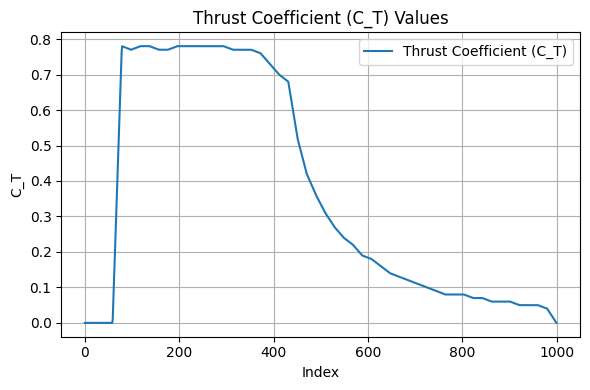

In [47]:
# Park Setup

theta_deg = -45
theta = np.radians(theta_deg)
resolution = 10

# Define the unit vectors in original directions
dx = np.array([s_x, 0])
dy = np.array([0, s_y])

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Rotate the unit vectors
dx_rot = R @ dx
dy_rot = R @ dy

# Projected spacings along global x and y
s_x_global = np.abs(dx_rot)
s_y_global = np.abs(dy_rot)

s_x = s_x_global[0] + s_x_global[1]
s_y = s_y_global[0] + s_y_global[1]

#print(f"s_x: {s_x}, s_y: {s_y}")

# Initialize thrust curve
u = np.arange(0, 26, .5)  # [m/s]
C_T_var = np.array([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0])

# Interpolate thrust curve
u_interp = np.linspace(u.min(), u.max(), 1000)
C_T_interp = interp1d(u, C_T_var, kind='linear')(u_interp)

plt.figure(figsize=(6, 4))
plt.plot(C_T_interp, label='Thrust Coefficient (C_T)')
plt.xlabel('Index')
plt.ylabel('C_T')
plt.title('Thrust Coefficient (C_T) Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

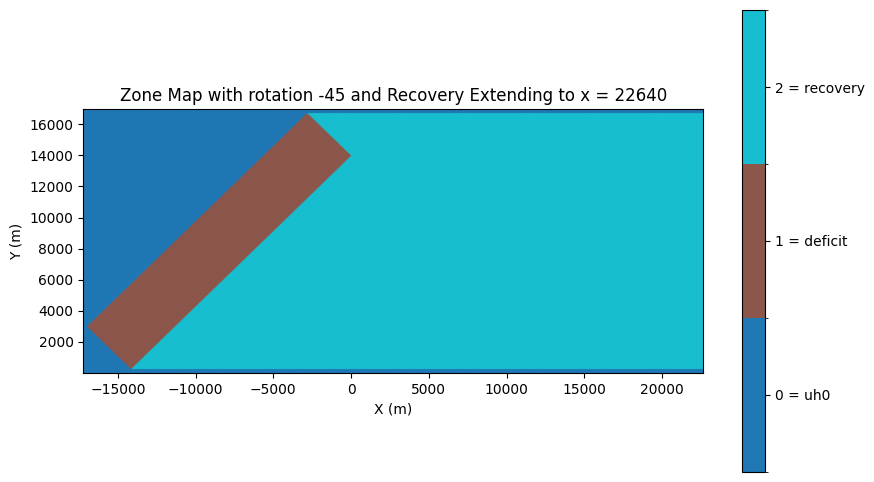

In [48]:
# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 250  # meters
    y_padding = 250  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding


    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range


# --- Define park shape ---
#corner_points = [(0, 0), (200, 0), (200, 100),(150, 100), (150, 50), (50, 50), (50, 100),(0, 100)]
corner_points = [(0, 0), (0, 20000), (4000, 20000), (4000, 0)] # Rectangle
#corner_points = [(0, 0), (300, 0), (300, 100), (200, 100), (200, 50), (100, 50), (100, 100), (0, 100)] # U-shape
#corner_points = [(0, 0), (150, 0), (150, 50), (50, 50), (50, 150), (0, 150)] # L-shape
#corner_points = [(0, 0), (200, 0), (200, 50), (125, 50), (125, 100), (200, 100), (200, 150), (0, 150), (0, 100), (75, 100), (75, 50), (0, 50)] # Hourglass
#corner_points = [(x * 100, y * 100) for x, y in corner_points]
rotation_degrees = theta_deg
mirror_axis = 'x'
recovery_x_end = 5660*4  # set recovery limit

# Generate mask
mask_2d, x_range, y_range = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size > 0:
        # Identify gaps between clusters of ones
        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        # Mark each deficit segment
        for start, end in zip(segment_starts, segment_ends):
            zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

        # Mark gaps in between as recovery
        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

        # Mark recovery zone after the last deficit
        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = ZONE_RECOVERY


# --- Plot ---
plt.figure(figsize=(10, 6))

row_indices = np.where(mask_2d.any(axis=1))[0]
park_y_min = y_range[row_indices[0]]
park_y_max = y_range[min(row_indices[-1] + 1, len(y_range) - 1)]

extent = [x_range[0], x_range[-1], park_y_min, park_y_max]

# Define a discrete colormap with 3 colors (you can choose your own)
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])  # Blue, Brown, Cyan
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['0 = uh0', '1 = deficit', '2 = recovery'])

plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.ylim(park_y_min, park_y_max)
plt.show()

In [49]:
def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    c_t = (np.pi * C_T * D**2)/(8 * s_d * s_c)

    nu_star = 28 * np.sqrt(c_t)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D/(2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa/np.log((z_H / z_0) * (1 - D/(2 * z_H))**beta))**2)**-0.5)

    x = np.linspace(x_1, x_3+1, int(x_3))

    h1 = np.full_like(x, np.nan, dtype=float)
    h2 = np.full_like(x, np.nan, dtype=float)

    h1[x > x_1] = z_H + ((x[x > x_1]) / z_0WF)**(4/5)
    h2[x > x_2] = ((x[x>x_2]-x_2)/z_0WF)**(4/5)

    uw = np.full_like(x, np.nan, dtype=float)
    uw[0] = U_0

    idx1 = h1 >= z_H
    uw[idx1] = U_0 * (np.log(h1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h1[idx1] / z_0WF) * np.log(z_H/z_0))

    idx2 = (x > x_2) & (h2 >= z_H)
    uw[idx2] = U_0 * (np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z_0WF)) / (np.log(h1[idx2] / z_0WF) * np.log(h2[idx2] / z_0))

    return x, uw

In [50]:
def calculate_wind_speed_iterative(x_1, x_2, x_3, z_H, D, s_d, s_c, uw_initial, tol=0.01, max_iter=100):

    x = np.linspace(x_1, x_3+1, int(x_3))
    uw_x = uw_initial.copy()  # Initial guess

    for iteration in range(max_iter):
        # Interpolate to get C_T from current uw_x
        C_T_id = np.abs(uw_x[:, None] - u_interp).argmin(axis=1)
        C_T_x = C_T_interp[C_T_id]

        c_t = (np.pi * C_T_x * D**2) / (8 * s_d * s_c)

        nu_star = 28 * np.sqrt(c_t)
        beta = nu_star / (1 + nu_star)

        z_0WF = z_H * (1 + D/(2 * z_H))**beta * np.exp(
            -kappa * (c_t + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5
        )

        h1 = np.full_like(x, np.nan, dtype=float)
        h2 = np.full_like(x, np.nan, dtype=float)

        h1[x >= x_1] = z_H + ((x[x >= x_1]) / z_0WF)**(4/5)
        h2[x > x_2] = ((x[x > x_2] - x_2) / z_0WF[x > x_2])**(4/5)

        uw_new = np.full_like(x, np.nan, dtype=float)

        idx1 = h1 >= z_H
        uw_new[idx1] = U_0 * (
            np.log(h1[idx1] / z_0) * np.log(z_H / z_0WF)
        ) / (
            np.log(h1[idx1] / z_0WF) * np.log(z_H / z_0)
        )

        idx2 = (x > x_2) & (h2 >= z_H)
        uw_new[idx2] = U_0 * (
            np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z_0WF[idx2])
        ) / (
            np.log(h1[idx2] / z_0WF[idx2]) * np.log(h2[idx2] / z_0)
        )

        # Check convergence
        delta = np.nanmax(np.abs(uw_new - uw_x))
        #print(f"Iteration {iteration + 1}, max delta uw: {delta:.4f} m/s")

        if delta < tol:
            break

        uw_x = uw_new.copy()

    return x, uw_x, c_t

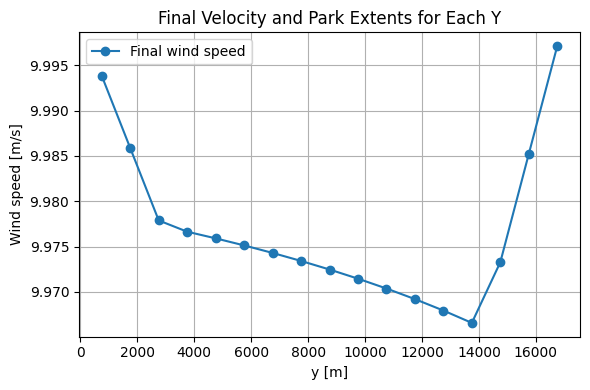

In [51]:
# Arbitrary TDM 

y_resolution = 100

results = []

for y_idx in range(0, len(y_range), y_resolution):
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    # Identify all contiguous non-zero zones (deficit or recovery)
    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):  # Note: range goes one past the end now
    # At the end of row or if zone changes
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):  # Don't update past end of row
                start_idx = idx
                current_zone_type = row[idx]

# Initialize velocity profile collector with more data
final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0  # Set U_h0 as a constant 10 m/s

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        # Nygaard setup
        '''C_T_id = np.abs(uw[:, None] - u_interp).argmin(axis=1)
        ct_val = C_T_interp[C_T_id]
        ct = (np.pi * ct_val * D**2) / (8 * s_x * D * s_y * D)
        nu_star = 28 * np.sqrt(ct)
        beta = nu_star / (1 + nu_star)
        z0_WF = z_H * (1 + D / (2 * z_H))**beta * np.exp(-k * (ct + (k / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5)'''

        # ----------------------- ITERATIVT LOOP ------------------------

        x, uw = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)
        #x_x, uw_x, ct_var = calculate_wind_speed_iterative(x_1, x_2, x_3, z_H, D, s_x*D, s_y*D, uw)
        
        """
        plt.figure(figsize=(6, 3))
        plt.axhline(y=U_0, color='purple', linestyle='--', label=f'U_0 ({U_0:.0f} m/s)')
        plt.plot(x, uw, label='Constant thrust', color='red')
        plt.plot(x_x, uw_x, label='Variable thrust', color='blue', linestyle='dashed')
        plt.xlabel('Downstream distance [m]')
        plt.ylabel('Wind speed [m/s]')
        plt.legend(loc='best')
        plt.title(f'Constant VS variable thrust at y = {y:.0f}')
        plt.grid(True)
        plt.show()
        """
        # ---------------------------------------------------------------

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue
        '''
        h1 = np.full_like(x, np.nan, dtype=float)
        h2 = np.full_like(x, np.nan, dtype=float)
    
        dx_h1 = np.clip(x - x_1, 1e-3, None)
        h1[:] = z_H + (dx_h1 / z0_WF) ** (4 / 5)

        dx_h2 = np.clip(x - x_2, 1e-3, None)
        h2[:] = (dx_h2 / z0_WF) ** (4 / 5)

        idx1 = h1 >= z_H
        uw[idx1] = previous_recovery_end_uw * (np.log(h1[idx1] / z_0) * np.log(z_H / z0_WF)) / \
                                          (np.log(h1[idx1] / z0_WF) * np.log(z_H / z_0))

        idx2 = (x > x_2) & (h2 >= z_H)
        uw[idx2] = previous_recovery_end_uw * (np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z0_WF[idx2])) / \
                                               (np.log(h1[idx2] / z0_WF[idx2]) * np.log(h2[idx2] / z_0))
        '''
        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        # Save full result (unshifted x1 and x3)
        final_velocity_data.append((y, recovery_end_uw, zone1['start_x'], zone1['end_x']))

        i += 2
    else:
        i += 1

# Convert to structured array: [y, final_velocity, x_start, x_end]
final_velocity_profile = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

# Final plot
plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile[:, 0], final_velocity_profile[:, 1], marker='o', label='Final wind speed')
plt.xlabel('y [m]')
plt.ylabel('Wind speed [m/s]')
plt.title('Final Velocity and Park Extents for Each Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

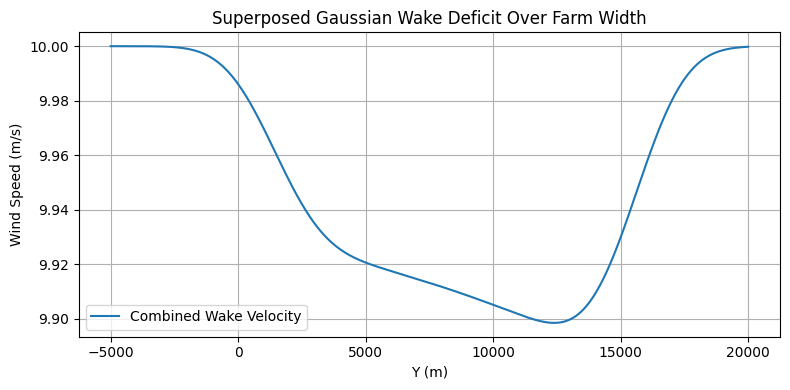

In [52]:
# Weighted Wake Distribution
U_inf = 10.0
k_w = 0.035
# Recovery length has  to be variable for each y-row

# Common lateral array across farm width
y = np.linspace(-5000, 20000, 25000)

# Initialize total deficit array
total_deficit = np.zeros_like(y)

u_si_array = []
u_ci_array = []

# Loop over each row in final_velocity_profile
for i in range(len(final_velocity_profile)):
    y_i = final_velocity_profile[i][0]  # y-position of this turbine/wake
    u_i = final_velocity_profile[i][1]  # velocity after recovery at y_i
    delta_u_max = U_inf - u_i

    # Variable wake spread
    sigma = k_w * (recovery_x_end - final_velocity_data[0][3]) + D / 2

    # Gaussian deficit centered at y_i
    u_si = delta_u_max * np.exp(-((y - y_i) ** 2) / (2 * sigma ** 2))
    u_wi = U_inf - u_si
    u_si_array.append(u_si)

    Top = u_wi * u_si
    Top_int = np.trapezoid(Top, y)
    
    Bot = u_si
    Bot_int = np.trapezoid(Bot, y)

    u_ci = Top_int / Bot_int
    u_ci_array.append(u_ci)

U_C = np.mean(u_ci_array)

U_S_array = []

for i in range(len(final_velocity_profile)):
    weight = u_ci_array[i] / U_C
    vel = weight * u_si_array[i][:]
    U_S_array.append(U_inf/len(final_velocity_data) - vel)

for i in range(len(final_velocity_profile)):
    total_deficit += U_S_array[i]

final_waked_velocity_1 = total_deficit

plt.figure(figsize=(8, 4))
#plt.plot(y, u_w_combined, label='Combined Wake Velocity')
plt.plot(y, final_waked_velocity_1, label='Combined Wake Velocity')
plt.xlabel('Y (m)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Superposed Gaussian Wake Deficit Over Farm Width')
plt.legend()
plt.grid(True)

# Turn off scientific notation for both axes
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(useOffset=False, style='plain')

plt.tight_layout()
plt.show()